In [1]:
import scipy.io as sco
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

AnalysisDate='20141124'
data=sco.loadmat('./data/VOD_{}.mat'.format(AnalysisDate))

In [2]:
date=['20141103','20141104','20141105','20141106','20141107', 
      '20141110', '20141111','20141112', '20141113','20141114',
      '20141117', '20141118','20141119', '20141120','20141121',
      '20141124']


''' 
statistics: 
===========
   quantity relative ratio  
   [past five days' ave]
''' 
_ix=date.index(AnalysisDate)
hist_date=date[_ix-6:_ix]
print("Hist:\n=====")
for item in hist_date:
    print(item)
print('\n\n\n')

Hist:
=====
20141114
20141117
20141118
20141119
20141120
20141121






 
__Limit Order Book__   

 

 
 


 

In [3]:
'''
Order flow_summary: columns
=====================

  0: total count of Buy and Sell market orders during that second of the trading day
  1: total volume of Buy and Sell market orders during that second of the trading day
  2: time stamp milliseconds from midnight at the start of the second
  
'''

def dTime(x): 
    H=str(int(x*0.001/3600))
    M=str(int((x*0.001/3600)%1*60))
    h='0'*(2-len(H))+H; 
    m='0'*(2-len(M))+M; 
    return '{}:{}'.format(h,m)


#quantity relative ratio
hd=sco.loadmat('./data/VOD_{}.mat'.format(hist_date[0]))
ht=pd.DataFrame.from_dict(hd['LOB'][0][0][2])
ht.columns=['dtime']
ht['dtime']=ht['dtime'].apply(dTime)
ht[date[0]]=np.sum(hd['LOB'][0][0][1][:,:2], axis=1).astype('int') 
ht=ht[(ht['dtime']>='09:30')&(ht['dtime']<='16:00')]  
ht=ht.groupby('dtime').sum()
ht.reset_index(inplace=True)
for _ in hist_date[1:]:
    t=sco.loadmat('./data/VOD_{}.mat'.format(_))
    v=pd.DataFrame.from_dict(t['LOB'][0][0][2])
    v.columns=['dtime']
    v['dtime']=v['dtime'].apply(dTime)
    v[_]=np.sum(t['LOB'][0][0][1][:,:2], axis=1).astype('int') 
    v=v[(v['dtime']>='09:30')&(v['dtime']<='16:00')]  
    v=v.groupby('dtime').sum()
    v.reset_index(inplace=True)
    ht=pd.merge(ht, v, on='dtime')
ht.set_index('dtime',inplace=True)
avevol=ht.mean().mean()



#intraday analysis: 
dt=pd.DataFrame.from_dict(data['LOB'][0][0][2]) #col 2
dt.columns=['dtime']
dt['dtime']=dt['dtime'].apply(dTime)
dt['buyNum']=data['LOB'][0][0][0][:,0]; 
dt['sellNum']=data['LOB'][0][0][0][:,1] #col 0
dt['buyVol']=data['LOB'][0][0][1][:,0]; 
dt['sellVol']=data['LOB'][0][0][1][:,1] #col 1
dt['Vol']=dt['buyVol']+dt['sellVol']




'''
Limit Order Book_summary:
===================

  3: The list of limit order buy prices at the start of the second
  4: The list of limit order sell prices at the start of the second
  5: The list of limit order buy volumes  
  6: The list of limit order sell volumes  
  
'''
dt['BuyPx1']=data['LOB'][0][0][3][:,0] *0.0001
dt['SellPx1']=data['LOB'][0][0][4][:,0] *0.0001
dt['BuyVol']=np.sum(data['LOB'][0][0][5][:,:5], axis=1).astype('int') 
dt['SellVol']=np.sum(data['LOB'][0][0][6][:,:5], axis=1).astype('int')
dt['Imb_LOB']=(dt['BuyVol'] -dt['SellVol'])/(dt['BuyVol'] +dt['SellVol']) 
 
df=pd.DataFrame(columns=list(dt.columns)+['QRR'])
ix=0
for name, group in dt.groupby('dtime'):
    df.loc[ix]=[name,
                group.buyNum.sum(), 
                group.sellNum.sum(),
                group.buyVol.sum(), 
                group.sellVol.sum(),
                group.Vol.sum(),
                group.BuyPx1.tail(1).values[0],   
                group.SellPx1.tail(1).values[0],
                group.BuyVol.tail(1).values[0], 
                group.SellVol.tail(1).values[0],
                group.Imb_LOB.mean(),
                (group.Vol.sum()+df['Vol'].sum())/(avevol*(ix+1))
               ]
    ix+=1 
df['mid']=0.5*(df['BuyPx1']+df['SellPx1'])
df.set_index('dtime', inplace=True)
  
df.head()

,buyNum,sellNum,buyVol,sellVol,Vol,BuyPx1,SellPx1,BuyVol,SellVol,Imb_LOB,QRR,mid
dtime,,,,,,,,,,,,
09:30,8,7,5930,2206,8136,35.40,35.41,63823,35900,0.084952,4.621346,35.405
09:31,7,13,4929,5230,10159,35.39,35.41,73941,46066,0.144587,5.195890,35.400
09:32,3,7,1200,1800,3000,35.39,35.40,62141,40497,0.152753,4.031939,35.395
09:33,7,0,2006,0,2006,35.40,35.41,81524,41135,0.170033,3.308812,35.405
09:34,5,4,2500,2083,4583,35.40,35.41,51341,34767,0.237658,3.167690,35.405


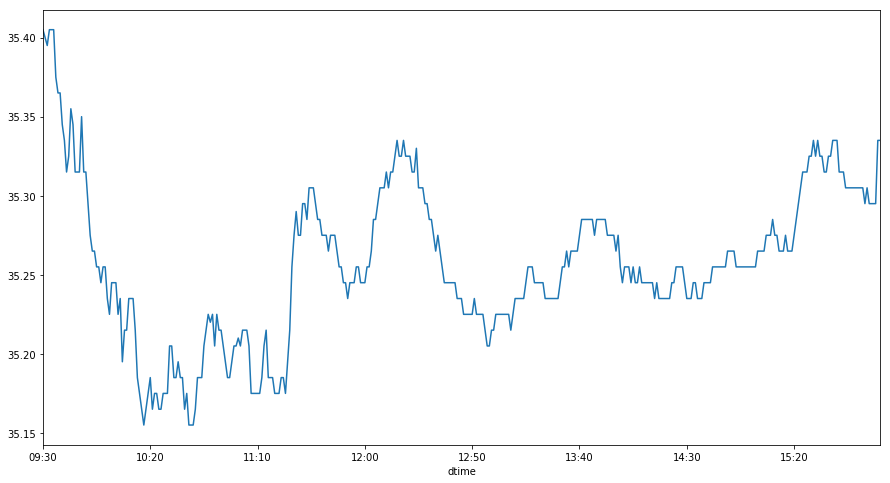

In [4]:
df['mid'].plot(figsize=(15,8));

---
__Order Imbalance (Imb_LOB)__
$$
\rho_t=\frac{V_t^b-V_t^a}{V_t^a+V_t^b} 
$$

``This is a measure of the buy versue sell pressure on an asset and contains predictive power on both the arrival rates of MOs, and the direction and size of future price movements``

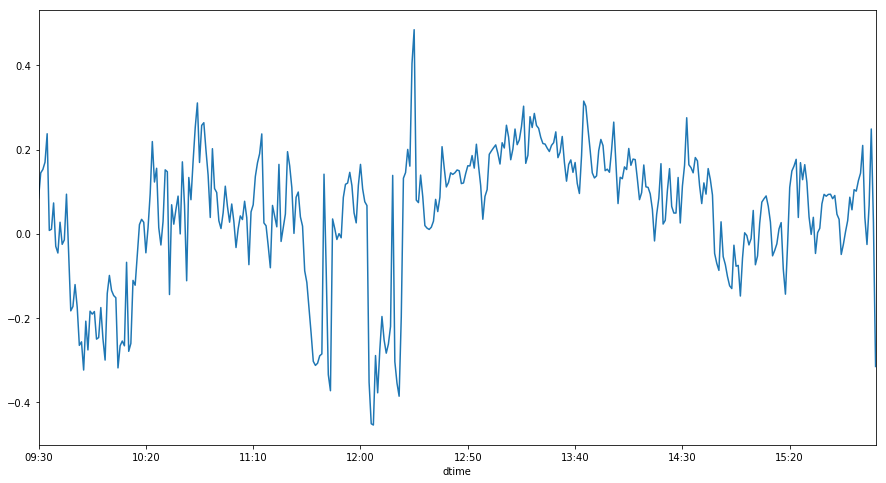

In [5]:
df['Imb_LOB'].plot(figsize=(15,8));

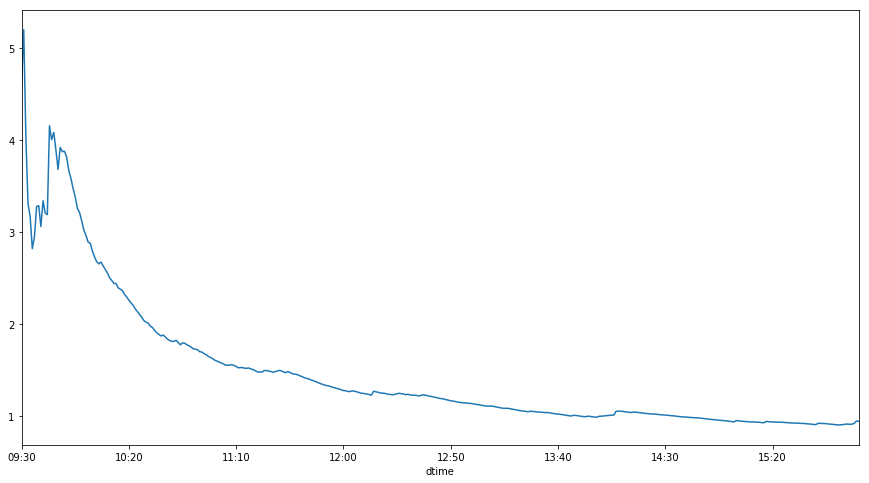

In [6]:
df['QRR'].plot(figsize=(15,8));

---

Market Order Flow Info

---

In [7]:
#MO
MO=pd.DataFrame.from_dict(data['LOB'][0][0][7][:,0])  #col 0
MO.columns=['ms']
MO['B/S']=data['LOB'][0][0][7][:,7]
MO['Vol']=data['LOB'][0][0][7][:,6]
MO['Price']=data['LOB'][0][0][7][:,5]*0.0001
MO.index=MO['ms'].apply(dTime)
MO=MO[(MO.index>='09:30') & (MO.index<='16:00')]
MO.head()

,ms,B/S,Vol,Price
ms,,,,
09:30,34205606.0,-1.0,127.0,35.37
09:30,34207250.0,-1.0,316.0,35.37
09:30,34212236.0,-1.0,557.0,35.37
09:30,34235394.0,-1.0,100.0,35.38
09:30,34235573.0,1.0,100.0,35.39


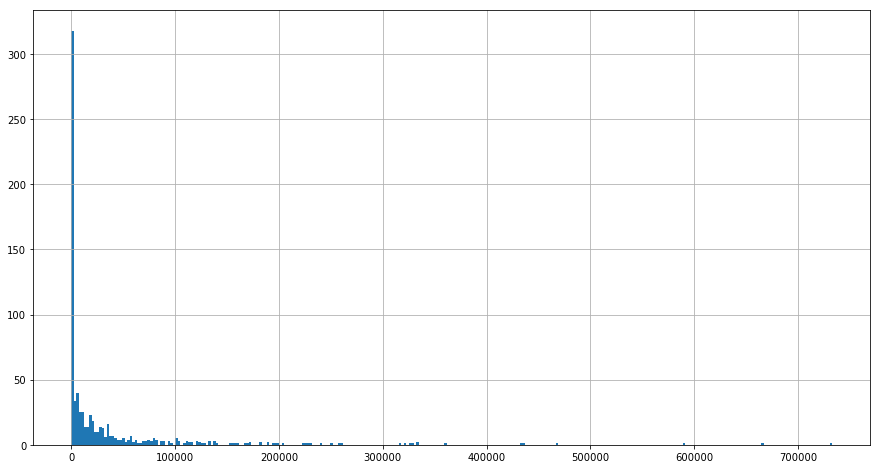

In [8]:
#inter-arrival time: Sell
#exponentially distributed 
MO[MO['B/S']>0]['ms'].diff(1).iloc[10:].hist(bins=300, figsize=(15,8));

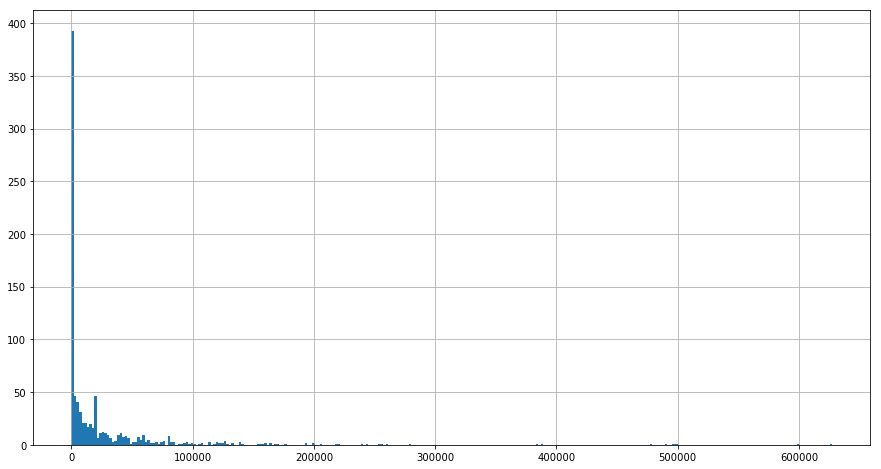

In [9]:
#inter-arrival time: Buy
MO[MO['B/S']<0]['ms'].diff(1).iloc[10:].hist(bins=300, figsize=(15,8));

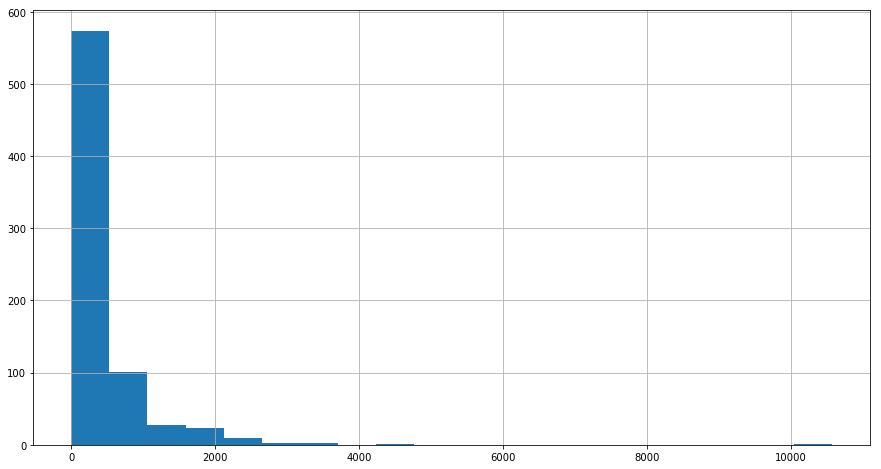

In [10]:
#Sell order 
MO[MO['B/S']>0]['Vol'].hist(bins=20, figsize=(15,8));

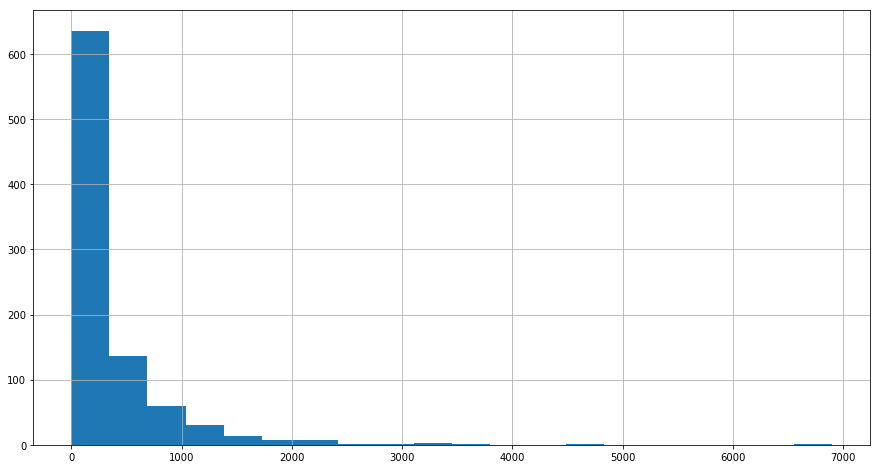

In [11]:
#Buy order 
MO[MO['B/S']<0]['Vol'].hist(bins=20, figsize=(15,8));

---